In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
data_dir = 'demo/'
demo_file = data_dir + 'evacuaters_demo.json'
time_file = data_dir + 'tweet_times_positive.csv'
demo_pred_file = data_dir + 'evacuaters_predicted_demo.json'
time_pred_file = data_dir + 'tweet_times_predpos.csv'

In [3]:
def read_demo(file):
    demodfs = {}
    with open(file) as f:
        for line in f:
            obj = json.loads(line)
            for attr, data in obj['user_demographics'].items():
                demodfs.setdefault(attr, []).append(dict(screen_name=obj['screen_name'], **data))
    return {name: pd.DataFrame(df) for name, df in demodfs.items()}

def read_time(file):
    return {row['user_screen_name']: row['tweet_time'] for idx, row in pd.read_csv(file).iterrows()}

In [4]:
demos = read_demo(demo_file)

In [5]:
for name, df in demos.items():
    print(name)
    display(df.head(2))

Age


,screen_name,18-24,25-34,35-44,45-54,55-64,65+
0,mbrouseoh,0.000380,0.000788,0.287552,0.698994,1.209409e-02,0.000192
1,AimsEconomics,0.000431,0.999519,0.000013,0.000022,5.872326e-07,0.000015


Children


,screen_name,Has Kids,No Kids
0,mbrouseoh,0.039233,0.960767
1,AimsEconomics,0.130832,0.869168


Education


,screen_name,College,Grad School,No College
0,mbrouseoh,0.843586,0.154051,0.002363
1,AimsEconomics,0.014026,0.985593,0.000381


Ethnicity


,screen_name,African American,Asian,Caucasian,Hispanic
0,mbrouseoh,0.024237,0.002609,0.972405,0.000750
1,AimsEconomics,0.000015,0.999661,0.000288,0.000036


Gender


,screen_name,Female,Male
0,mbrouseoh,0.001353,0.998647
1,AimsEconomics,0.999994,0.000006


Income


,screen_name,$0-50k,$100-150k,$150k+,$50-100k
0,mbrouseoh,0.000017,0.953087,0.015230,0.031665
1,AimsEconomics,0.003233,0.000217,0.941062,0.055489


Politics


,screen_name,Democrat,Republican
0,mbrouseoh,0.058036,0.941964
1,AimsEconomics,0.730123,0.269877


In [6]:
tweet_times = read_time(time_file)
len(tweet_times)

1461

In [10]:
def get_times_by_cat(demos, ttimes, attr):
    cdict = {'African American': 'Black', 'Caucasian': 'White'}
    df = demos[attr]
    times_by_cat = {}
    for idx, row in df.iterrows():
        if attr == 'Age': # 18-34, 35+
            cat = '18-34' if row[['18-24', '25-34']].sum() > .5 else '35+'
        elif attr == 'Income': # $0-100k, $100k+
            cat = '$0-100k' if row[['$0-50k', '$50-100k']].sum() > .5 else '$100k+'
        else:
            cat = max(df.columns[1:], key=lambda c: row[c])
            cat = cdict.get(cat, cat)
        times_by_cat.setdefault(cat, []).append(ttimes[row.screen_name])
    return times_by_cat

def plot_times_rolling(times, ax, label, win_size):
    vals = [{label: 1}] * len(times)
    idx = sorted([pd.Timestamp(t) for t in times])
    pd.DataFrame(vals, index=idx).rolling(f'{win_size}H').sum().plot(ax=ax, legend=True)

def plot_times_cumulative(times, ax, label, interval, percentage=True):
    start = pd.Timestamp('2017-09-04 00:00:00')
    def get_time_group(t, start, interval):
        return start + interval * ((t - start) // interval + 1)
    
    vals = [{label: 1}] * len(times)
    idx = sorted([pd.Timestamp(t) for t in times])
    cnts = pd.DataFrame(vals, index=idx).groupby(lambda t: get_time_group(t, start, interval)).sum()
    ((cnts * 100 / len(times)) if percentage else cnts)[cnts.index < pd.Timestamp('2017-09-14 00:00:00')].cumsum().plot(ax=ax, legend=percentage)

def plot_times_by_category(demos, ttimes, attr, cumulative=False, pred=False):
    times_by_cat = get_times_by_cat(demos, ttimes, attr)
    prefix = ' predicted' if pred else ''
    if cumulative:
        fig, axs = plt.subplots(1, 2, figsize=(9.6, 3.2), dpi=200)
        for i, perc in enumerate([False, True]):
            ax = axs[i]
            intv = 1
            for cat in sorted(times_by_cat):
                times = times_by_cat[cat]
                plot_times_cumulative(times, ax, f'{cat}: {len(times)}', pd.Timedelta(intv, unit='h'), perc)
            #ax.set_ylabel('%s%s evacuees (%dH interval)' % ('%' if perc else '#', prefix, intv))
            ax.set_ylabel('%s of%s evacuees' % ('percentage' if perc else 'number', prefix))
        #fig.suptitle(attr)
    else: # rolling window
        fig, ax = plt.subplots()
        for cat in sorted(times_by_cat):
            times = times_by_cat[cat]
            plot_times_rolling(times, ax, f'{cat}: {len(times)}', 5)
        ax.set_ylabel(f'#{prefix} evacuees ({5}H rolling window)')
        ax.set_title(attr)
    plt.show()

In [11]:
demos_pred = read_demo(demo_pred_file)
tweet_times_pred = read_time(time_pred_file)
len(tweet_times_pred)

2351

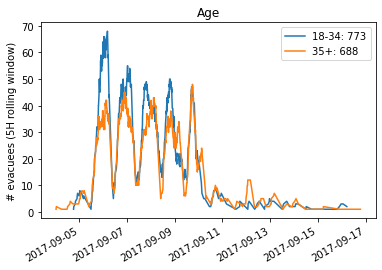

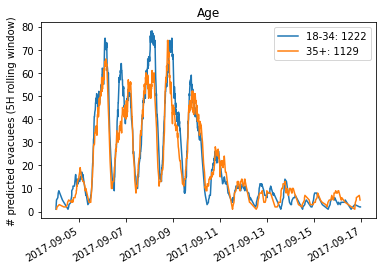

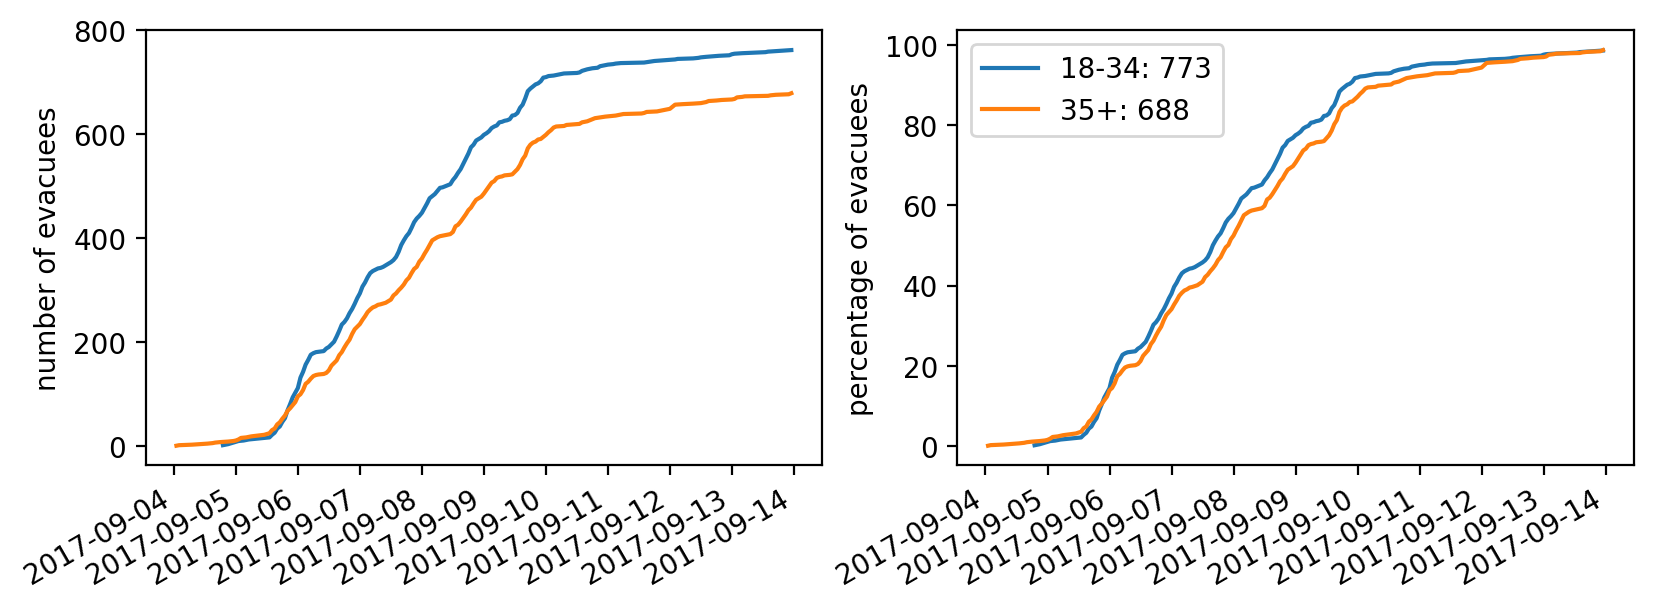

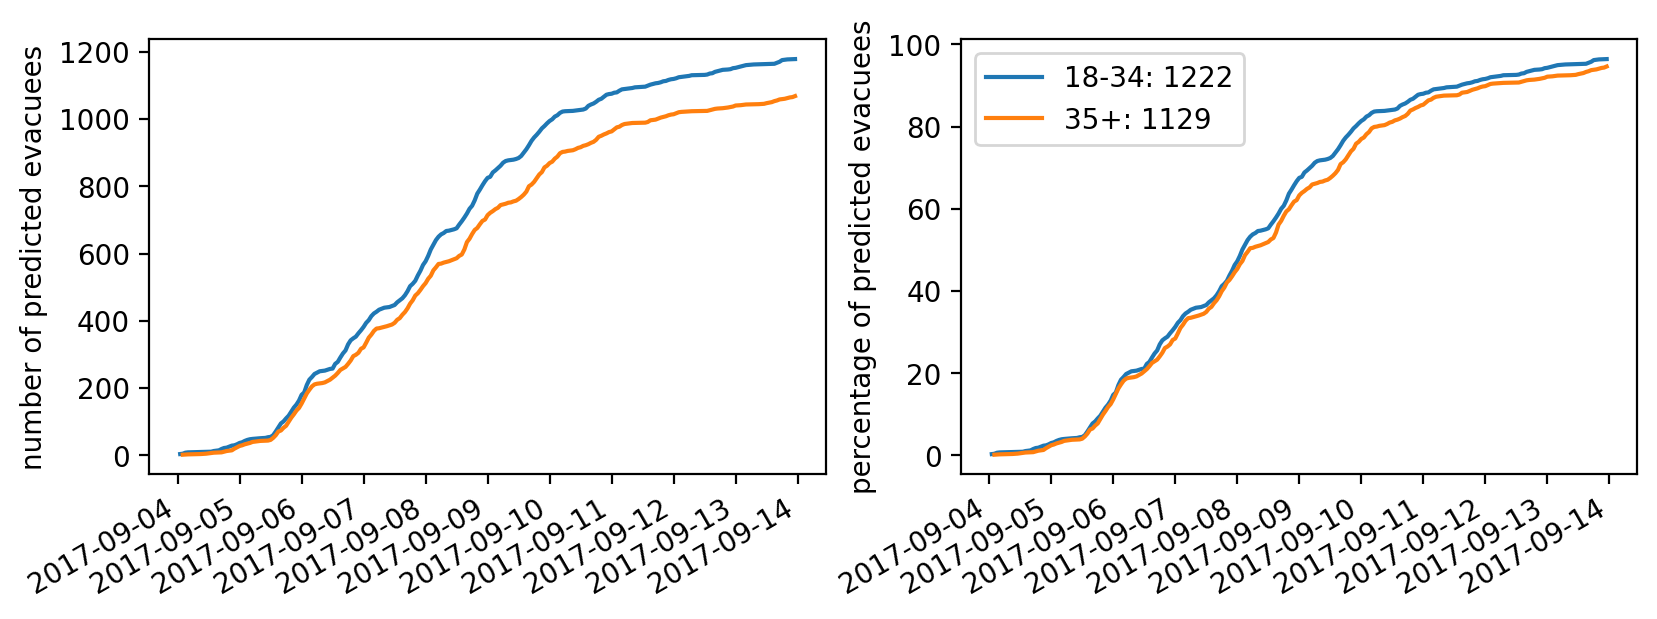

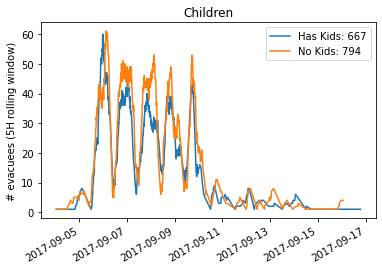

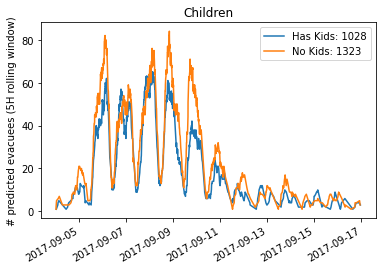

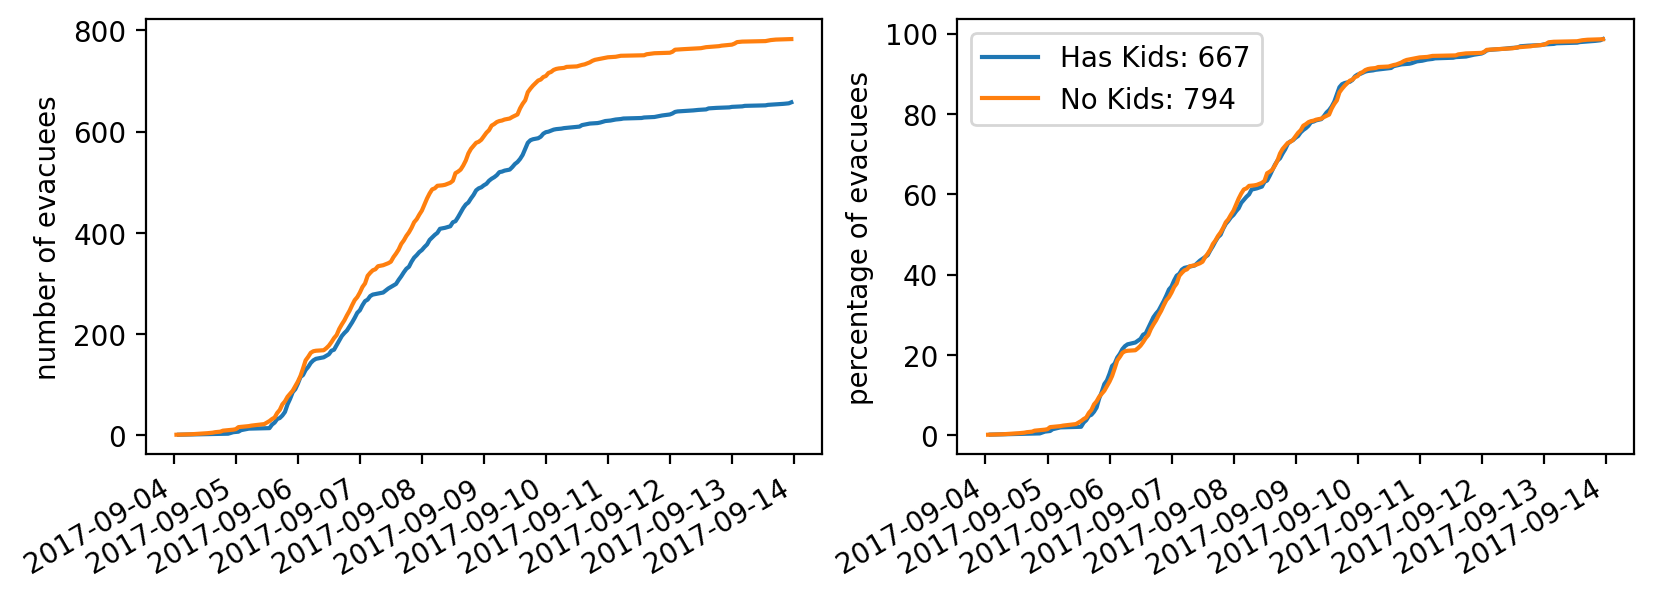

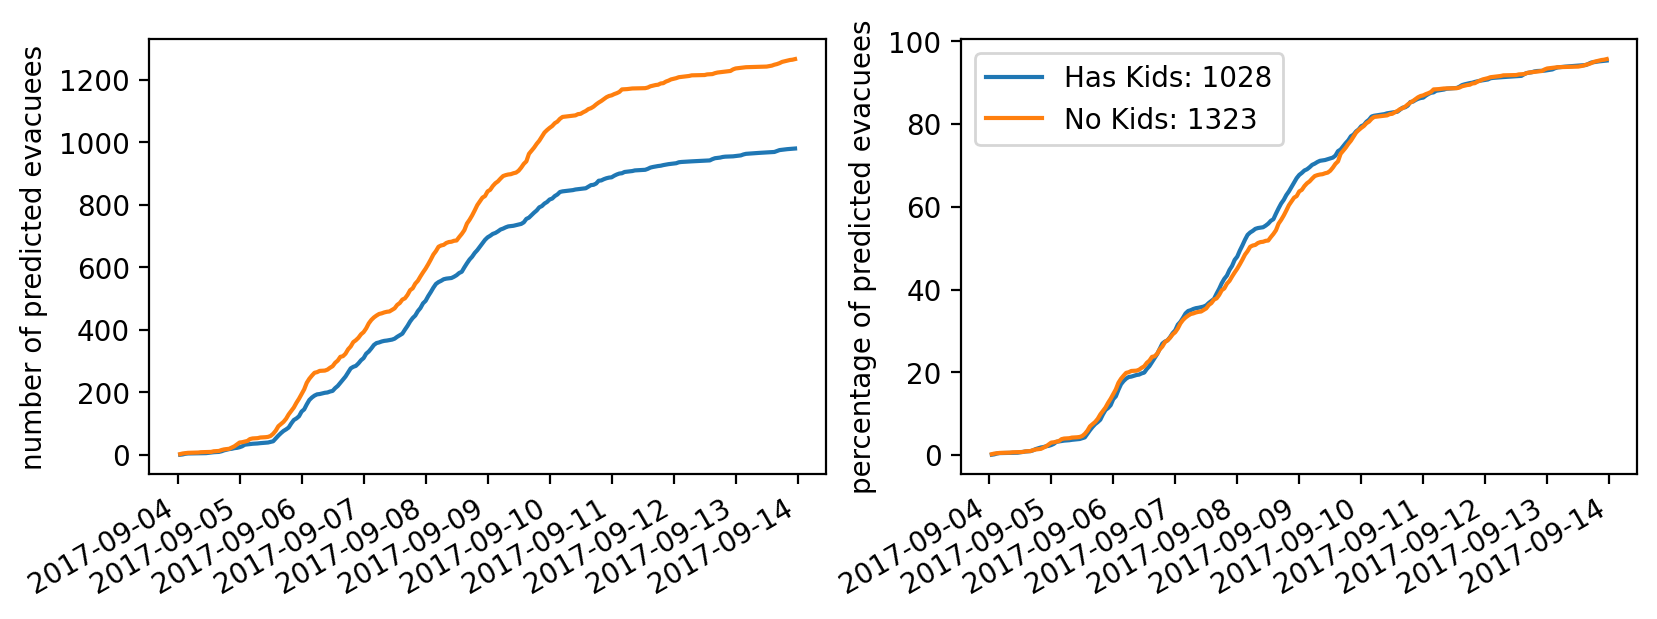

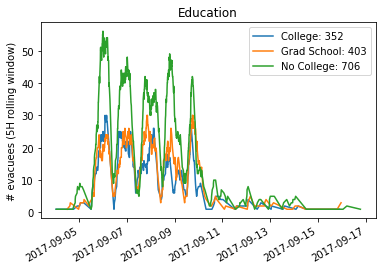

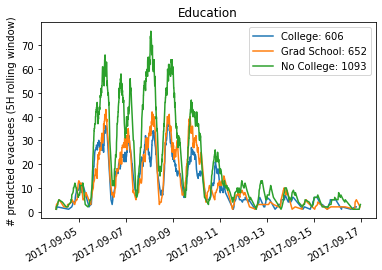

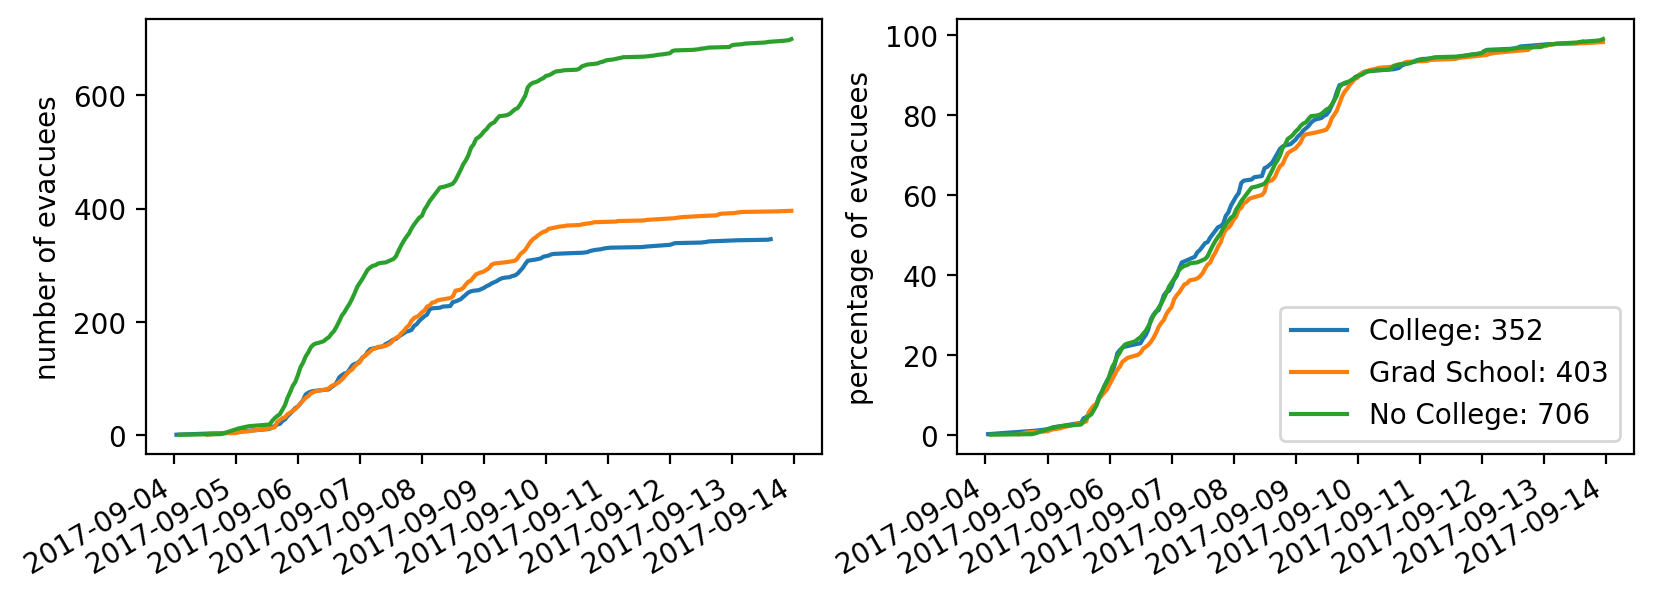

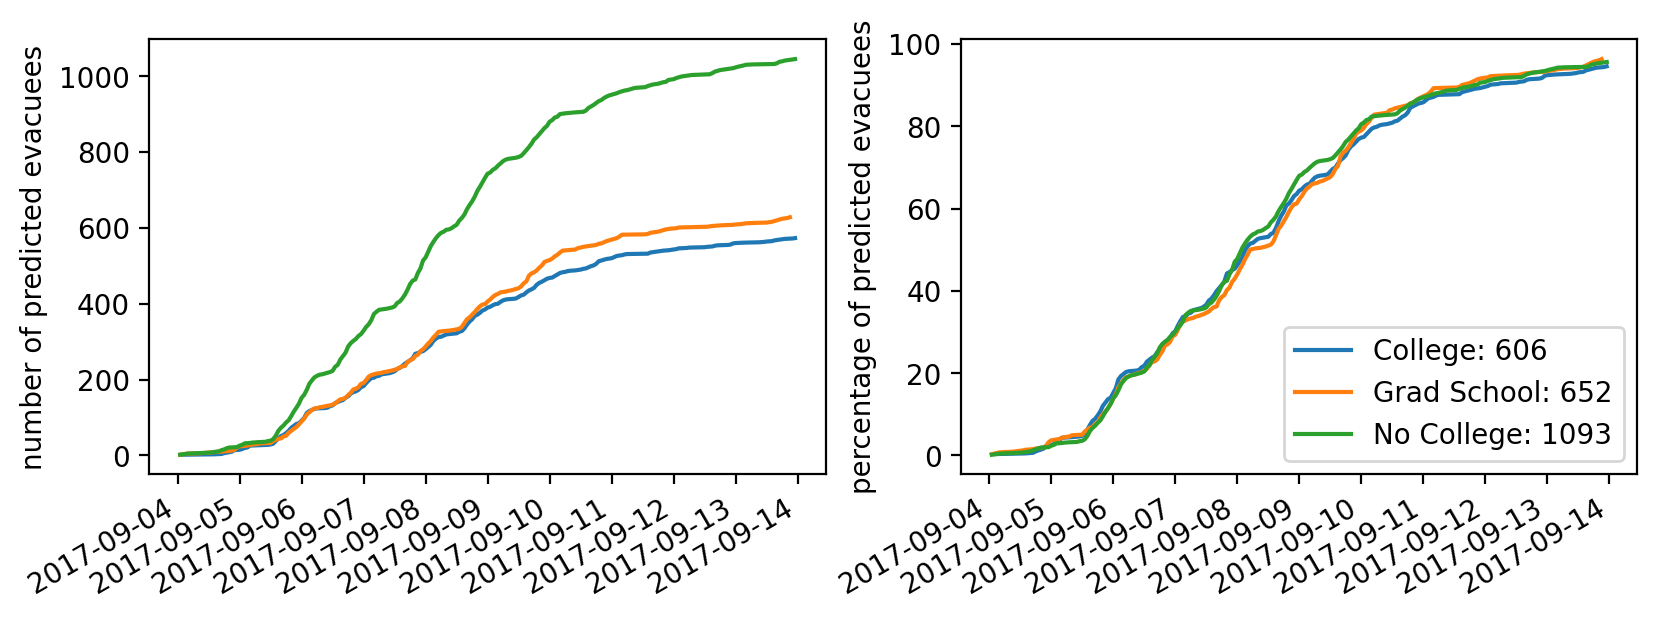

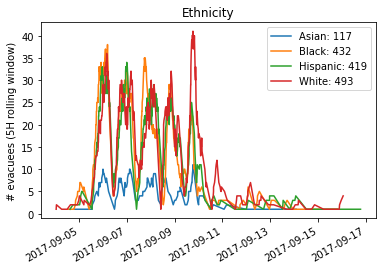

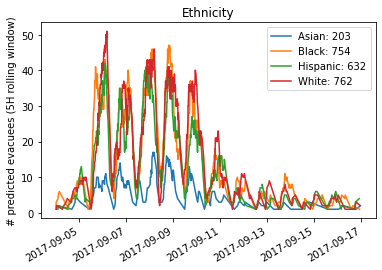

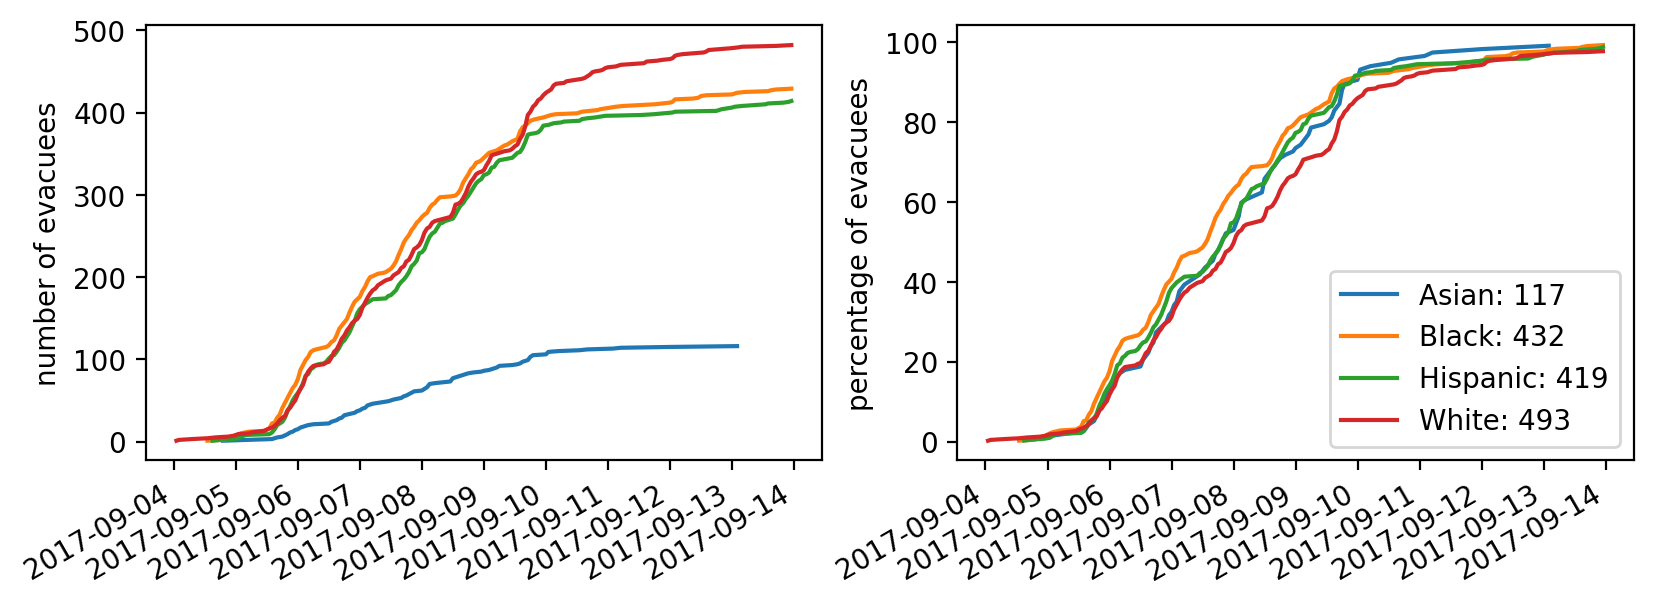

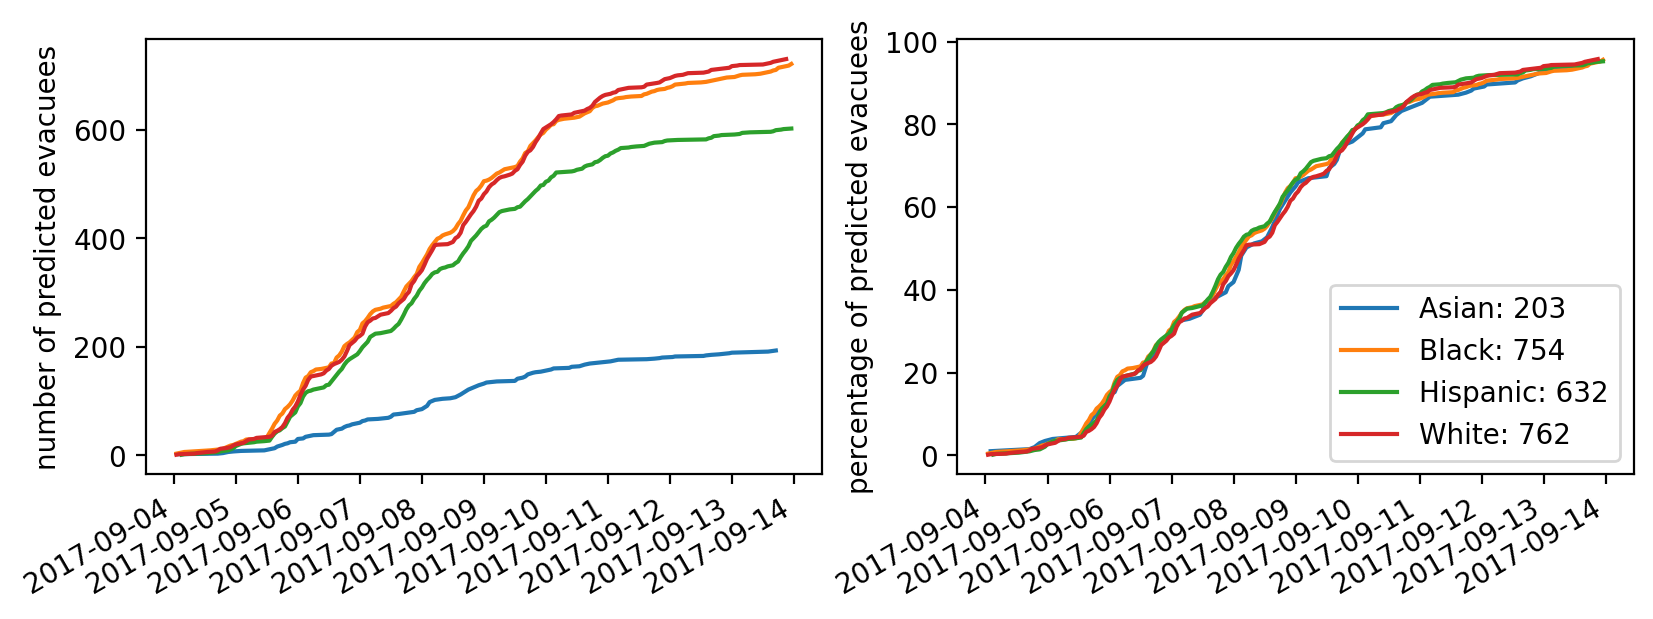

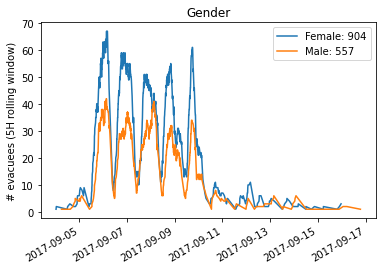

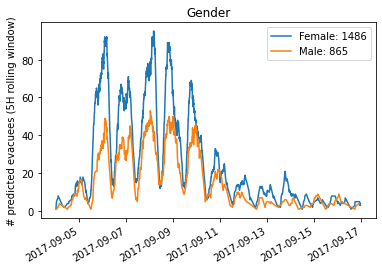

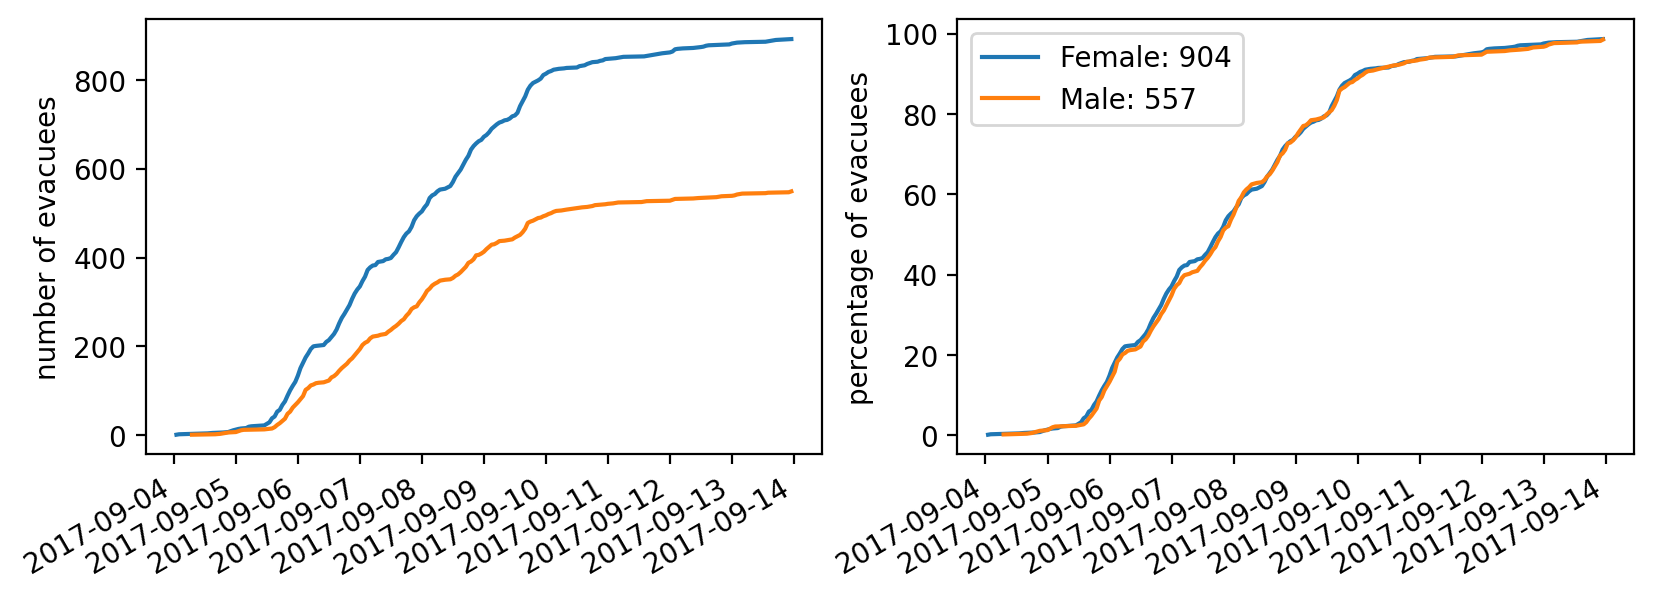

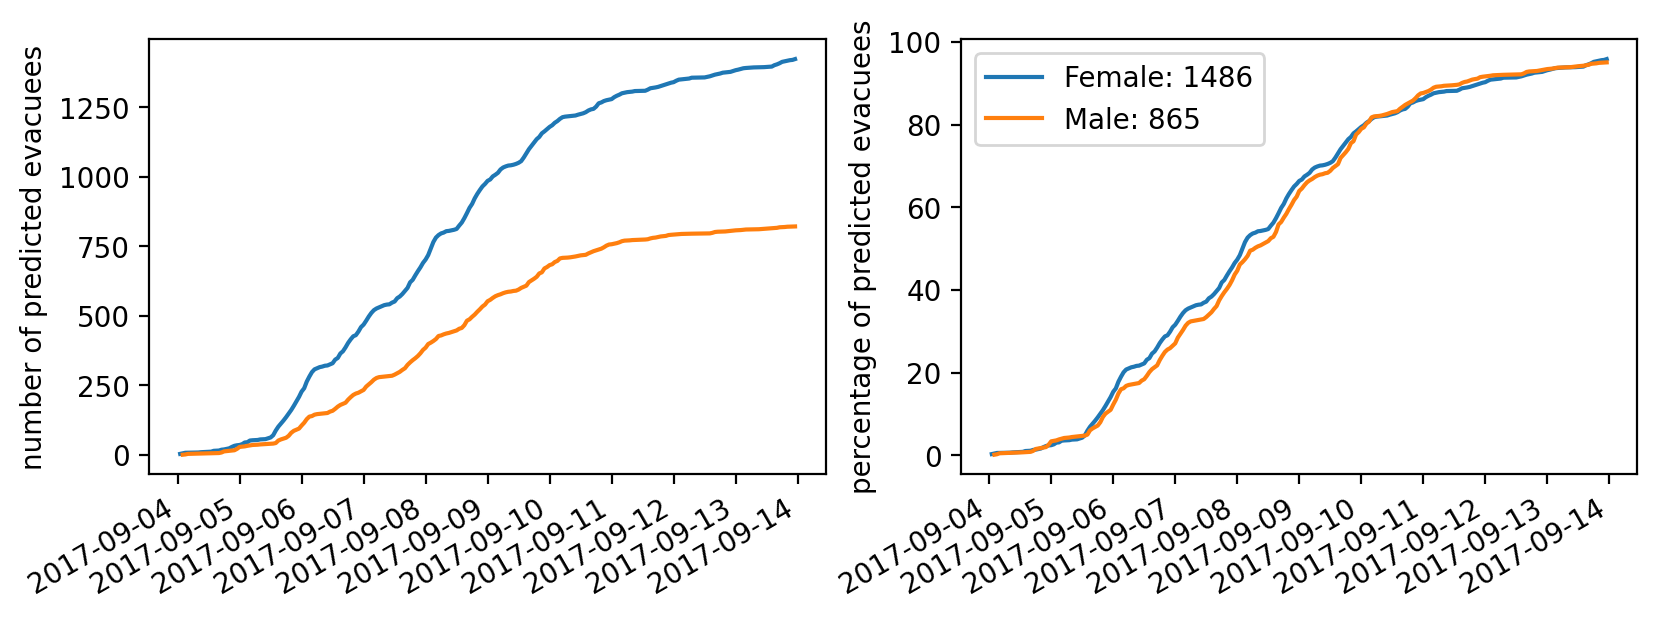

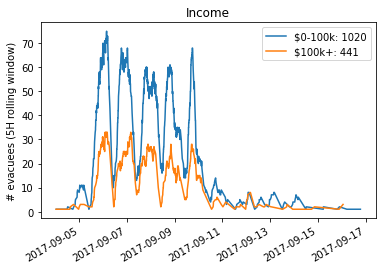

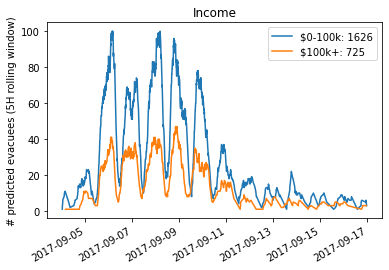

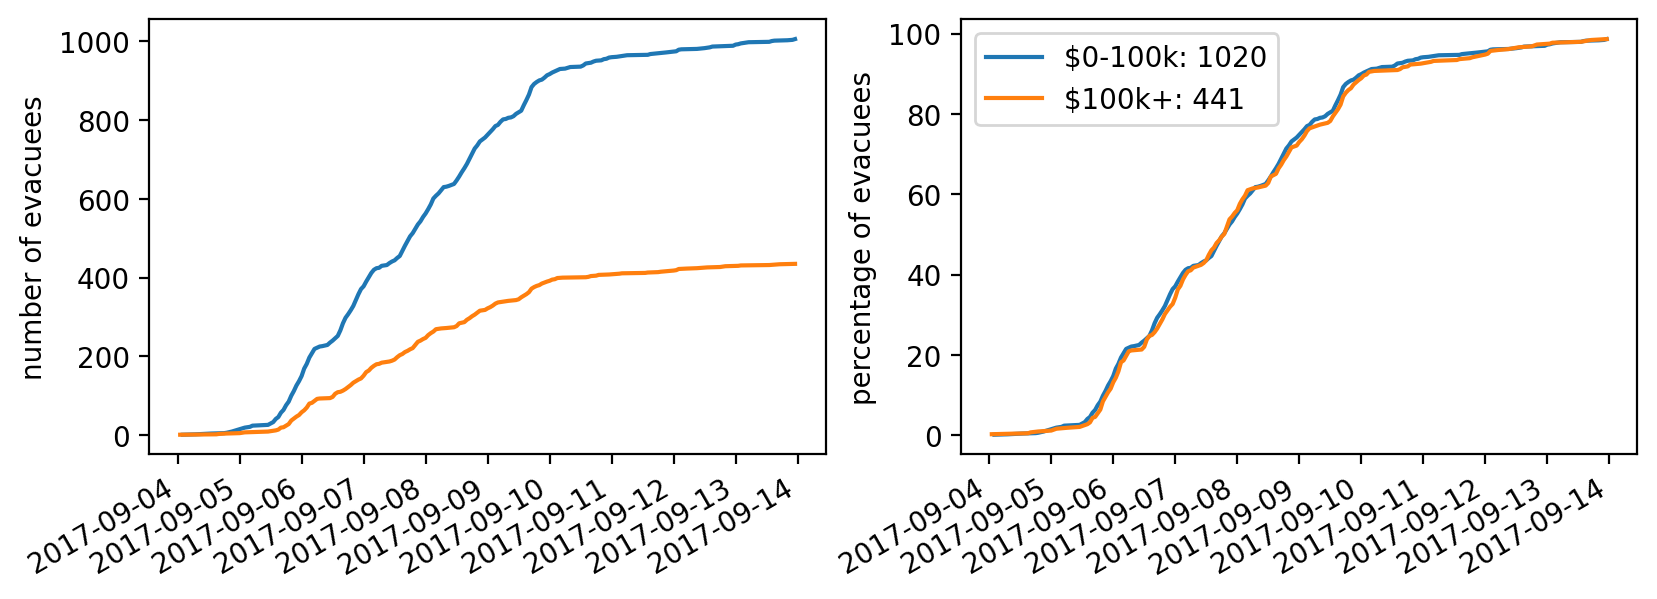

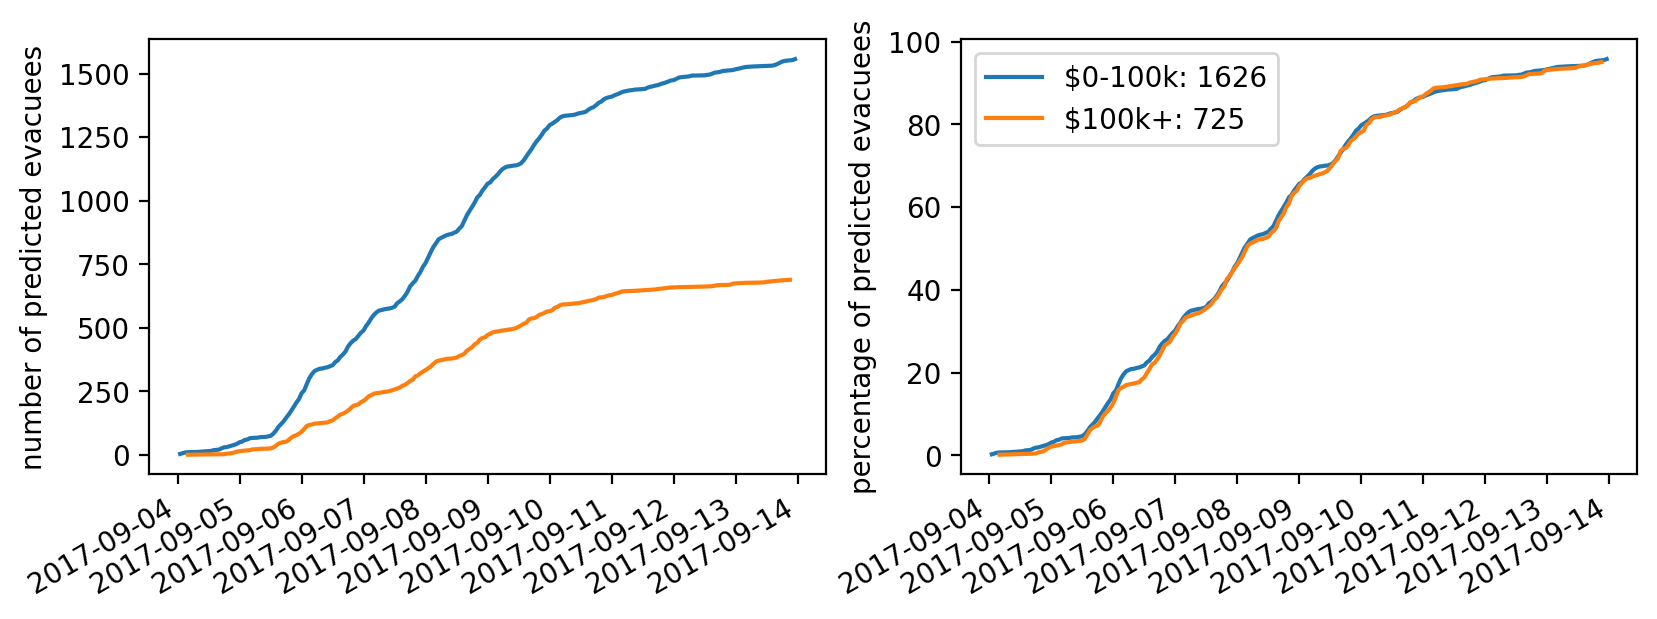

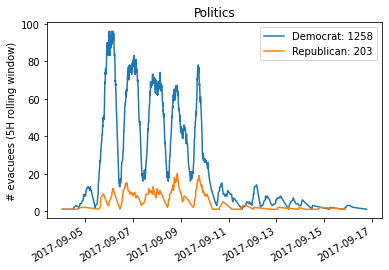

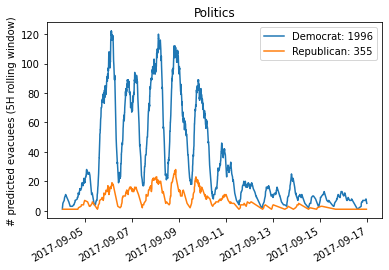

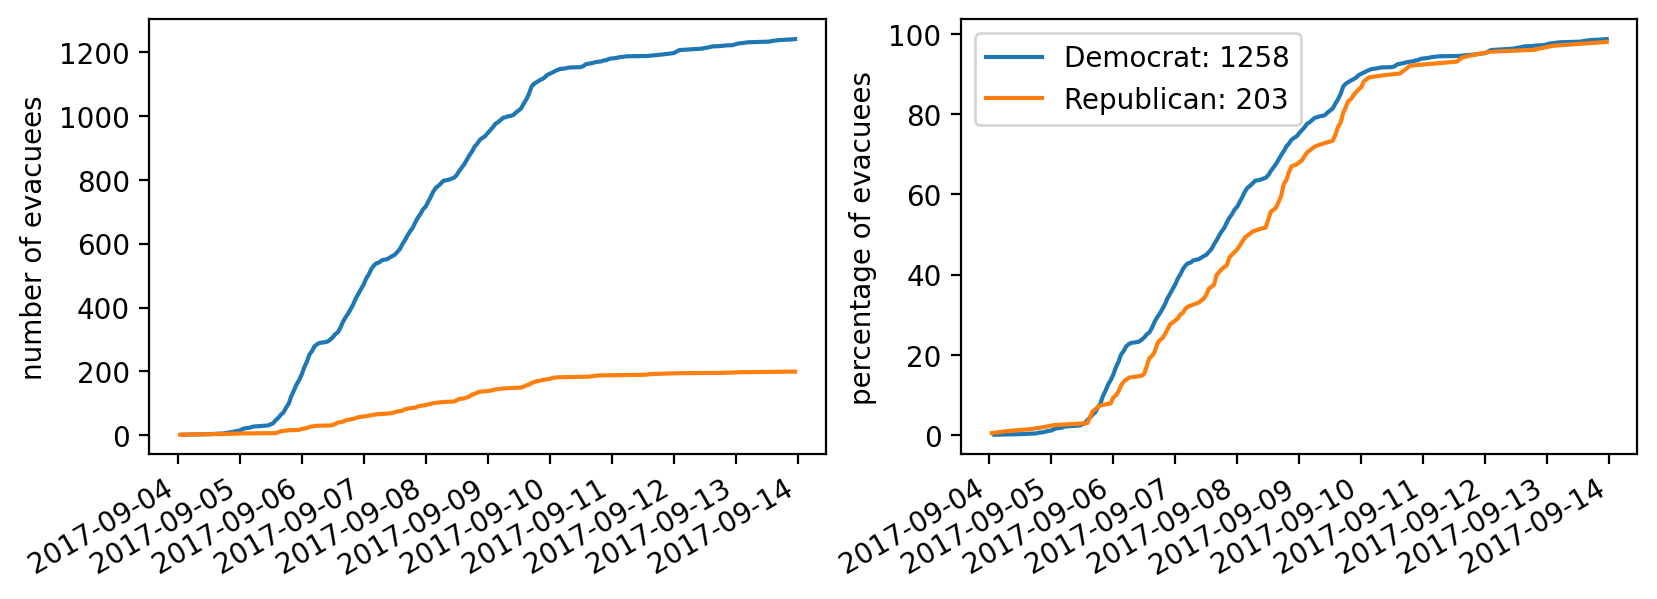

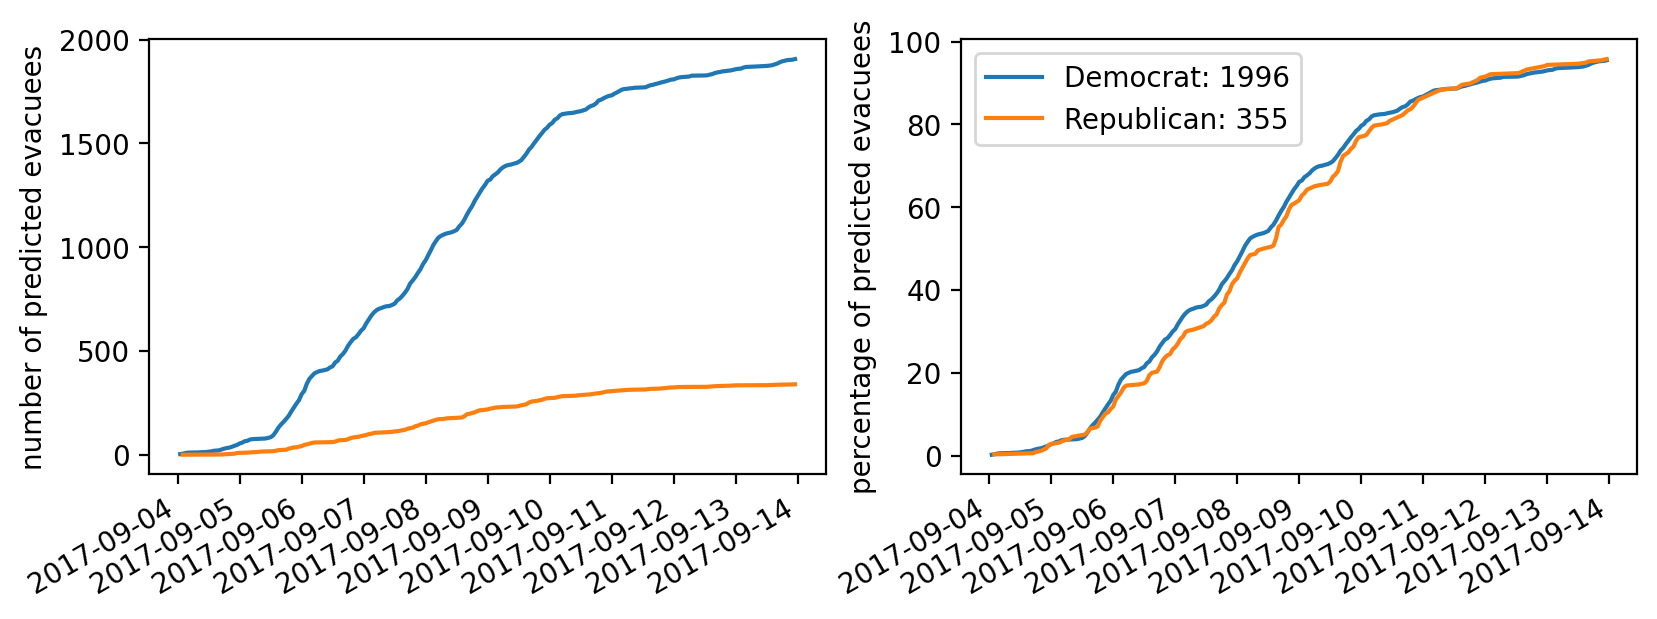

In [12]:
for attr in demos:
    plot_times_by_category(demos, tweet_times, attr)
    plot_times_by_category(demos_pred, tweet_times_pred, attr, pred=True)
    plot_times_by_category(demos, tweet_times, attr, cumulative=True)
    plot_times_by_category(demos_pred, tweet_times_pred, attr, cumulative=True, pred=True)